<a href="https://colab.research.google.com/github/lucas-fpaiva/AnalisePred_I/blob/main/Projeto/popularity_forro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Avaliar a popularidade de músicas de forro

In [74]:
import pandas as pd
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.datasets import make_classification



In [ ]:
forroset= pd.read_parquet('https://github.com/lucas-fpaiva/Forroset/blob/main/data/forroset.parq?raw=true', engine='auto')

In [ ]:
forroset.columns

Index(['track_id', 'track', 'artist', 'artist_id', 'popularity', 'album',
       'album_id', 'track_year', 'duration_ms', 'uri', 'preview_url', 'energy',
       'liveness', 'tempo', 'speechiness', 'acousticness', 'instrumentalness',
       'time_signature', 'danceability', 'key', 'loudness', 'valence', 'mode',
       'beats_start', 'beats_duration', 'beats_confidence', 'bars_start',
       'bars_duration', 'bars_confidence', 'tatums_start', 'tatums_duration',
       'tatums_confidence', 'librosa_beats_start', 'librosa_discrepancy',
       'tempo_bins', 'tempo_bins_max', 'genre_filt', 'folds', 'manual_filt',
       'lyrics'],
      dtype='object')

## Separando o treino e teste.

In [41]:
treino = forroset[forroset.folds>2][forroset.popularity>0]
teste = forroset[forroset.folds<3][forroset.popularity>0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [42]:
x_treino = treino[['energy', 'liveness', 'tempo', 'speechiness', 'acousticness', 'instrumentalness',
       'time_signature', 'danceability', 'key', 'loudness', 'valence', 'mode']]
y_treino = treino.popularity

x_teste = teste[['energy', 'liveness', 'tempo', 'speechiness', 'acousticness', 'instrumentalness',
       'time_signature', 'danceability', 'key', 'loudness', 'valence', 'mode']]
y_teste = teste.popularity

## Definindo os parâmetros do GridSearchCV

In [ ]:
def grid (model="DT", names=False, grid="", task="C"):
  #models = ["KNN","LM","DT","SVM", "RF", "MLP", "GB", "ADA"]
  #types = ["C","R"]
  if names == True:
    print("KNN: KNeighborsRegressor\nLM: LinearRegression\nDT: DecisionTreeRegressor\nRF: RandomForestRegressor",
          "\nGB: GradientBoostingRegressor\nSVM: SVR\nADA: AdaBoostRegressor\nMLP: MLPRegressor")
    
  if model == "DT":
    if task == "C":
      return DecisionTreeClassifier(max_depth=parameters[0],min_samples_leaf=parameters[1],criterion=parameters[2],random_state=0)
    elif task == "R":
      return DecisionTreeRegressor(max_depth=parameters[0],min_samples_leaf=parameters[1],criterion=parameters[2],random_state=0)
        
  if model=="MLP":
    if task == "C":
      return MLPClassifier(hidden_layer_sizes=(10,10), max_iter=10,random_state=0)
    elif task == "R":
      return MLPRegressor(hidden_layer_sizes=(10,10), max_iter=10,random_state=0)
    
  if model == "RF":
    if task == "C":
        return RandomForestClassifier(n_estimators=100,max_depth=10,random_state=0)
    elif task == "R":
        return RandomForestRegressor(n_estimators=100,max_depth=10,min_samples_leaf=10,random_state=0)
        
  return None

In [43]:
grid = { 
    'max_depth': [5,10,15,20,25],
    'min_samples_leaf': [1,2,3,4,5],
    'criterion' :['squared_error', 'absolute_error'],
    'random_state' : [0]
}

grid = { 
    'max_depth': [5,10,15,20,25],
    'min_samples_leaf': [1,2,3,4,5],
    'criterion' :['squared_error', 'absolute_error'],
    'random_state' : [0]
}

### Passando os parâmetros para o GridSearchCV

In [44]:
dtr_cv = GridSearchCV(estimator=DecisionTreeRegressor(), param_grid=grid, cv= 5, scoring='neg_mean_absolute_percentage_error')
dtr_cv.fit(x_treino, y_treino)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['squared_error', 'absolute_error'],
                         'max_depth': [5, 10, 15, 20, 25],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'random_state': [0]},
             scoring='neg_mean_absolute_percentage_error')

### Melhores parâmetros encontrados pelo GridSearchCV

In [45]:
dtr_cv.best_params_

{'criterion': 'absolute_error',
 'max_depth': 5,
 'min_samples_leaf': 3,
 'random_state': 0}

In [46]:
dtr_cv.best_score_

-2.8053790313495126

In [47]:
from random import random, seed
parameters = [dtr_cv.best_params_['criterion'], dtr_cv.best_params_['max_depth'], dtr_cv.best_params_['min_samples_leaf'], dtr_cv.best_params_['random_state']]
model = DecisionTreeRegressor(criterion=parameters[0],max_depth=parameters[1],min_samples_leaf=parameters[2],random_state=parameters[3]).fit(x_treino, y_treino)
print(model)
##scores = cross_val_score(model, x_treino, y_treino, cv=5, scoring='neg_mean_absolute_percentage_error')
##print(np.mean(scores))

DecisionTreeRegressor(criterion='absolute_error', max_depth=5,
                      min_samples_leaf=3, random_state=0)


In [ ]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

### Treino do modelo

In [ ]:
model = ml(random_state=0, max_depth=25)
model.fit(x_treino, y_treino)

DecisionTreeRegressor(max_depth=25, random_state=0)

In [48]:
np.sqrt(model.score(x_treino, y_treino))

0.040666408636989934

In [49]:
model.score(x_teste, y_teste)

-0.1065487447201241

In [50]:
y_pred_t = model.predict(x_treino)

In [51]:
y_pred= model.predict(x_teste)

In [ ]:
plt.plot(y_treino, y_pred_t, 'o')

plt.plot(y_teste, y_pred, 'x')


In [63]:
mape(y_teste,y_pred)

1.5077140219453673

150.77140219453676

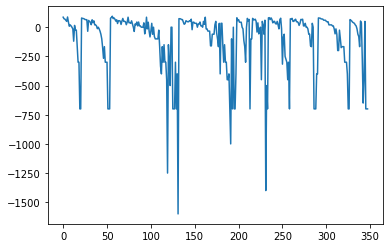

In [71]:
plt.plot(((y_teste.values - y_pred)/y_teste.values)*100)
np.mean(100*np.abs(y_teste.values - y_pred)/y_teste.values)

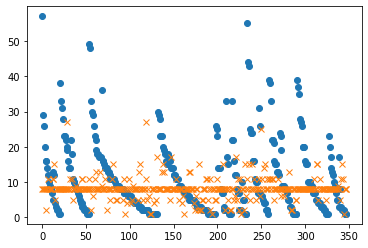

In [64]:
plt.plot(y_teste.values, 'o')
plt.plot(y_pred, 'x')

In [ ]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true+0.00001))) * 100

In [ ]:
def mae (y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

In [ ]:
def r2_score(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))

0.24169303797468356